# Setup

In [1]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from scipy.stats import linregress
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
import seaborn as sns

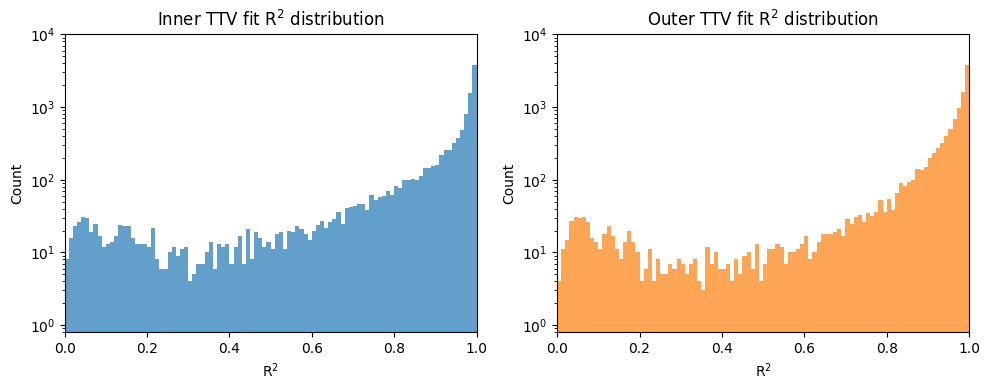

e1          w1        e2          w2     Delta  j  P1         P2  \
0  0.010486  205.597895  0.026567  141.633237  0.036704  3   7  10.885388   
1  0.029546  159.213181  0.001624  298.046206 -0.031463  3   7  10.169642   
2  0.009842   70.259984  0.012508   77.969656  0.012530  4   7   9.450276   
3  0.005481  321.089760  0.014841  297.967416 -0.014719  4   7   9.195957   
4  0.001464  226.866268  0.016764  337.950516  0.011824  4   7   9.443687   

            m1           m2  ...    phase1      std1        A2        B2  \
0   292.563842   349.200375  ...       NaN       NaN       NaN       NaN   
1     8.910582     0.485504  ...  5.760131  0.000158 -0.000214  0.000002   
2    17.244348  2633.795024  ...       NaN       NaN       NaN       NaN   
3  1137.567465   762.087758  ...       NaN       NaN       NaN       NaN   
4  1481.588474     0.739015  ...       NaN       NaN       NaN       NaN   

         V2       Pttv2    phase2      std2     R2_1     R2_2  
0       NaN         NaN       NaN       NaN      NaN      NaN  
1  0.005739  108.599092  2.633932  0.004049  0.94963  0.97669  
2       NaN         NaN       NaN       NaN      NaN      NaN  
3       NaN         NaN       NaN       NaN      NaN      NaN  
4       NaN         NaN       NaN       NaN      NaN      NaN  

[5 rows x 29 columns]

In [2]:
# Import CSV for fits
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order_TTVFast\lithwick_TTVFast_fits.csv")
total = len(fits)

# R2-score histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(fits['R2_1'], bins=100, color='C0', alpha=0.7, range=(0, 1))
ax[0].set_title('Inner TTV fit R$^2$ distribution')

ax[1].hist(fits['R2_2'], bins=100, color='C1', alpha=0.7, range=(0, 1))
ax[1].set_title('Outer TTV fit R$^2$ distribution')

for a in ax:
    a.set_xlabel('R$^2$'); a.set_ylabel('Count')
    a.set_ylim(0.8,1e+4); a.set_xlim(0,1)
    a.set_yscale('log')

plt.tight_layout()
plt.show()

fits.head()

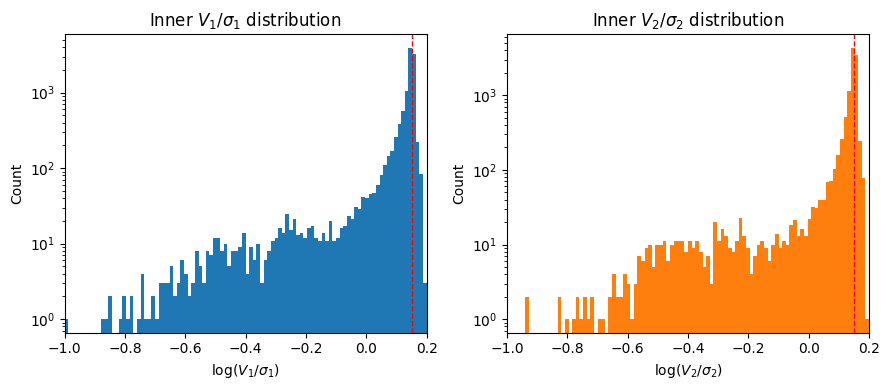

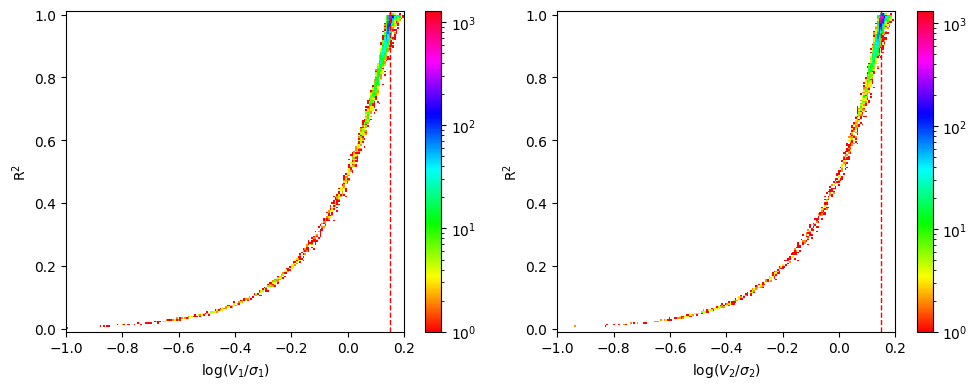

In [3]:
# Fit Amplitude / dispersion
amp_goodness1 = np.log10(np.abs(fits.V1) / fits.std1)
amp_goodness2 = np.log10(np.abs(fits.V2) / fits.std2)

# V/sigma histograms
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
rng = (-1, 0.2)
ax[0].hist(amp_goodness1, bins=100, range=rng, color='C0')
ax[1].hist(amp_goodness2, bins=100, range=rng, color='C1')

for i, a in enumerate(ax):
    a.set_title(f'Inner $V_{i+1}/\sigma_{i+1}$ distribution')
    a.set_yscale('log')
    a.set_xlim(rng)
    a.set_xlabel(f'$\log(V_{i+1}/\sigma_{i+1})$'); a.set_ylabel('Count')
    a.axvline(np.log10(np.sqrt(2)), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# V/sigma-R2 scatterplot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ax[0].scatter(amp_goodness1, fits.R2_1, s=1, color='C0')
# ax[1].scatter(amp_goodness2, fits.R2_2, s=1, color='C1')

rng = [(-1, 0.2), (-0.01, 1.01)]
h0 = ax[0].hist2d(amp_goodness1, fits.R2_1, bins=200, range=rng, norm=mcolors.LogNorm(), cmap='hsv')
h1 = ax[1].hist2d(amp_goodness2, fits.R2_2, bins=200, range=rng, norm=mcolors.LogNorm(), cmap='hsv')

plt.colorbar(h0[3], ax=ax[0])
plt.colorbar(h1[3], ax=ax[1])

for i, a in enumerate(ax):
    a.set_xlim(rng[0]), a.set_ylim(rng[1])
    a.set_xlabel(f'$\log(V_{i+1}/\sigma_{i+1})$'); a.set_ylabel('R$^2$')
    a.axvline(np.log10(np.sqrt(2)), color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

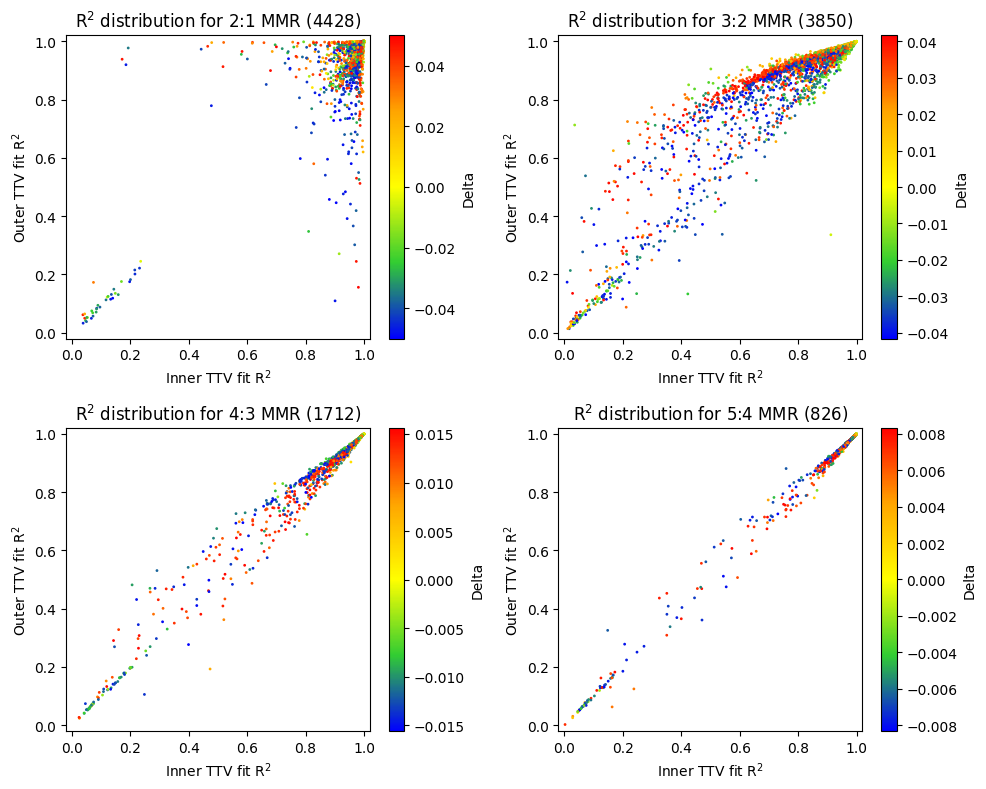

In [5]:
# R2-score scatterplots
fig, ax = plt.subplots(2, 2, figsize=(10,8))

for j, coords in zip(range(2,6), [(0,0),(0,1),(1,0),(1,1)]):
    ccol = 'Delta'  # Colormap column
    jmask = (fits.j == j) & (fits.valid == True)
    vmax = fits[ccol][jmask].max()
    vmin = fits[ccol][jmask].min()
    jtot = jmask.sum()

    # Create custom colormap: blue at vmin, yellow at 0, red at vmax
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    zero = (0 - vmin) / (vmax - vmin)
    colors = [
        (0.0, 'blue'),    # vmin
        ((0.0 + zero)/2, 'limegreen'),
        (zero, 'yellow'), # at 0
        ((1.0 + zero)/2, 'orange'),
        (1.0, 'red')      # vmax
    ]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
    
    sc = ax[coords].scatter(fits['R2_1'][jmask], fits['R2_2'][jmask], s=1,
                            c=fits[ccol][jmask], cmap=cmap)
    ax[coords].set_xlabel('Inner TTV fit R$^2$'); ax[coords].set_ylabel('Outer TTV fit R$^2$')
    ax[coords].set_xlim(-0.02,1.02); ax[coords].set_ylim(-0.02,1.02)
    ax[coords].set_title(f'R$^2$ distribution for {j}:{j-1} MMR ({jtot})')
    
    fig.colorbar(sc, ax=ax[coords], label='Delta')

plt.tight_layout()
plt.show()

In [6]:
# Filter by R2
# Minimum 10% percentile
p5_1 = np.nanpercentile(fits.R2_1, 10)
p5_2 = np.nanpercentile(fits.R2_2, 10)
print(f'Filter for R^2 (Inner TTV) and R^2 (Outer TTV): {p5_1:.3f}, {p5_2:.3f}')

R2_threshold = 0.5
R2_filter = (fits.R2_1 > p5_1) & (fits.R2_2 > p5_2)
fits = fits[R2_filter].reset_index()
good = len(fits)

print(f'Good systems: {good}/{total} ({(good/total) * 100:.2f}%)')

fits.head()

Filter for R^2 (Inner TTV) and R^2 (Outer TTV): 0.685, 0.788
Good systems: 9695/50000 (19.39%)


index        e1          w1        e2          w2     Delta  j  P1  \
0      1  0.029546  159.213181  0.001624  298.046206 -0.031463  3   7   
1      5  0.009029    1.796158  0.004746  257.200178 -0.001874  5   7   
2      8  0.002530  100.798272  0.016567   99.637520  0.038429  2   7   
3     14  0.034870  174.244943  0.018098  163.461676 -0.005177  5   7   
4     17  0.001254  295.465659  0.040271  276.500619 -0.046231  2   7   

          P2         m1  ...    phase1      std1        A2            B2  \
0  10.169642   8.910582  ...  5.760131  0.000158 -0.000214  1.903586e-06   
1   8.733601   0.614201  ...  3.669814  0.012697 -0.003369  2.894428e-06   
2  14.538010  72.349777  ...  0.595114  0.000193  0.000703  3.357057e-08   
3   8.704699   0.499981  ...  5.002950  0.004208  0.000170 -4.773862e-07   
4  13.352763   1.145732  ...  4.631847  0.001737  0.000023  4.074751e-08   

         V2       Pttv2    phase2      std2      R2_1      R2_2  
0  0.005739  108.599092  2.633932  0.004049  0.949630  0.976690  
1  0.010711  818.691582  0.510303  0.007500  0.999054  0.998983  
2  0.005850  195.240594  3.494568  0.004140  0.993930  0.983871  
3  0.003705  349.673024  1.863791  0.002580  0.993851  0.993949  
4  0.000136  143.907974  1.750301  0.000100  0.977760  0.914513  

[5 rows x 30 columns]

In [7]:
# Functions, returns in %
def relerr(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3) 
    relerrs = calc[nonan]/sol[nonan]
    return relerrs

def err_gmean(calc, sol):
    relerrs = relerr(calc, sol)
    gavg = gmean(relerrs)
    return gavg

def err_med(calc, sol):
    relerrs = relerr(calc, sol)
    med = np.median(relerrs)
    return med

def err_gstd(calc, sol):
    relerrs = relerr(calc, sol)    
    logs = np.log(relerrs)
    gstd = np.exp(logs.std(ddof=0))
    return gstd

def err_1sig_percentiles(calc, sol):
    relerrs = relerr(calc, sol)
    p16 = np.percentile(relerrs, 16)
    p84 = np.percentile(relerrs, 84)
    return p16, p84

def num2dex(x):
    return np.log10(x)

def returnMetrics(df, mask='all', mode='gstd'):
    if isinstance(mask, str):
        if (mask == 'all'):
            m = np.ones(len(df), dtype=bool)
    else:
        m = mask
        
    err1 = err_gmean(df['m_calc_in'][m], df['m1'][m])
    err2 = err_gmean(df['m_calc_out'][m], df['m2'][m])
    med1 = err_med(df['m_calc_in'][m], df['m1'][m])
    med2 = err_med(df['m_calc_out'][m], df['m2'][m])

    if mode == 'gstd':
        gstd1 = err_gstd(df['m_calc_in'][m], df['m1'][m])
        gstd2 = err_gstd(df['m_calc_out'][m], df['m2'][m])
    
        MetricArr = err1, err2, med1, med2, gstd1, gstd2
        MetricArr = num2dex(MetricArr)
        
    elif mode == 'percentile':
        p16_1, p84_1 = err_1sig_percentiles(df['m_calc_in'][m], df['m1'][m])
        p16_2, p84_2 = err_1sig_percentiles(df['m_calc_out'][m], df['m2'][m])

        MetricArr = err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2
        MetricArr = num2dex(MetricArr)
        
    return MetricArr

In [8]:
# Fit line y = kx + c
def getLineFit(calc, sol):
    nonan = ~np.isnan(calc) & ~np.isnan(sol) & (calc/sol < 1e+3) & (calc/sol > 1e-3)
    x, y = sol[nonan], calc[nonan]

    # Linear fit using scipy
    slope, intercept, _, _, _ = linregress(x, y)
    return slope, intercept

# Non-nominal validation

In [9]:
# Naive validation
valid = fits['valid']
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])

for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare = fits.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare['m_bad_in'] = mbad_in
compare['m_bad_out'] = mbad_out
compare.head()

100%|█████████████████████████████████████████████████████████████████████████████| 9695/9695 [00:58<00:00, 164.73it/s]


index        e1          w1        e2          w2     Delta  j  P1  \
0      1  0.029546  159.213181  0.001624  298.046206 -0.031463  3   7   
1      5  0.009029    1.796158  0.004746  257.200178 -0.001874  5   7   
2      8  0.002530  100.798272  0.016567   99.637520  0.038429  2   7   
3     14  0.034870  174.244943  0.018098  163.461676 -0.005177  5   7   
4     17  0.001254  295.465659  0.040271  276.500619 -0.046231  2   7   

          P2         m1  ...        V2       Pttv2    phase2      std2  \
0  10.169642   8.910582  ...  0.005739  108.599092  2.633932  0.004049   
1   8.733601   0.614201  ...  0.010711  818.691582  0.510303  0.007500   
2  14.538010  72.349777  ...  0.005850  195.240594  3.494568  0.004140   
3   8.704699   0.499981  ...  0.003705  349.673024  1.863791  0.002580   
4  13.352763   1.145732  ...  0.000136  143.907974  1.750301  0.000100   

       R2_1      R2_2  m_calc_in  m_calc_out   m_bad_in  m_bad_out  
0  0.949630  0.976690   9.366751    0.492416  49.704446   2.516956  
1  0.999054  0.998983   0.415034    0.830297   0.517140   0.999991  
2  0.993930  0.983871  79.079168    2.118394  60.453592   1.788456  
3  0.993851  0.993949   0.511195    0.984947   0.884023   1.652293  
4  0.977760  0.914513   1.142379   17.872727   1.945351  26.396619  

[5 rows x 34 columns]

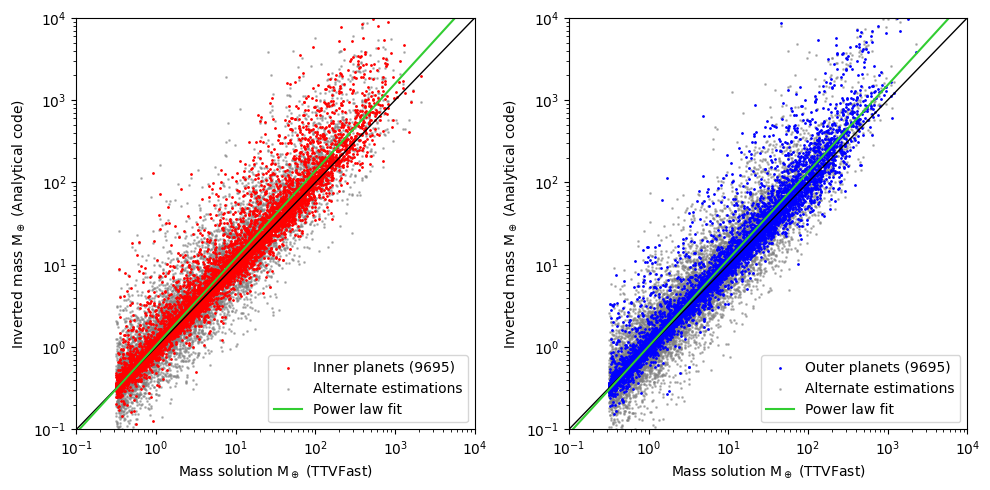

In [10]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4
linelim = np.array([minval, maxval])
scatterCount = len(compare['m1'])

# Inner planets
m1 = compare['m1']
m1_good = compare['m_calc_in']
m1_bad = compare['m_bad_in']
k1, c1 = getLineFit(np.log10(m1_good), np.log10(m1))

ax[0].scatter(m1, m1_good, s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(m1, m1_bad, s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot(linelim, linelim, color='black', lw=1, zorder=1)
ax[0].plot(linelim, 10**c1 * linelim**k1, color='limegreen', label=f'Power law fit')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
m2 = compare['m2']
m2_good = compare['m_calc_out']
m2_bad = compare['m_bad_out']
k2, c2 = getLineFit(np.log10(m2_good), np.log10(m2))

ax[1].scatter(m2, m2_good, s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(m2, m2_bad, s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot(linelim, linelim, color='black', lw=1, zorder=1)
ax[1].plot(linelim, 10**c2 * linelim**k2, color='limegreen', label=f'Power law fit')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

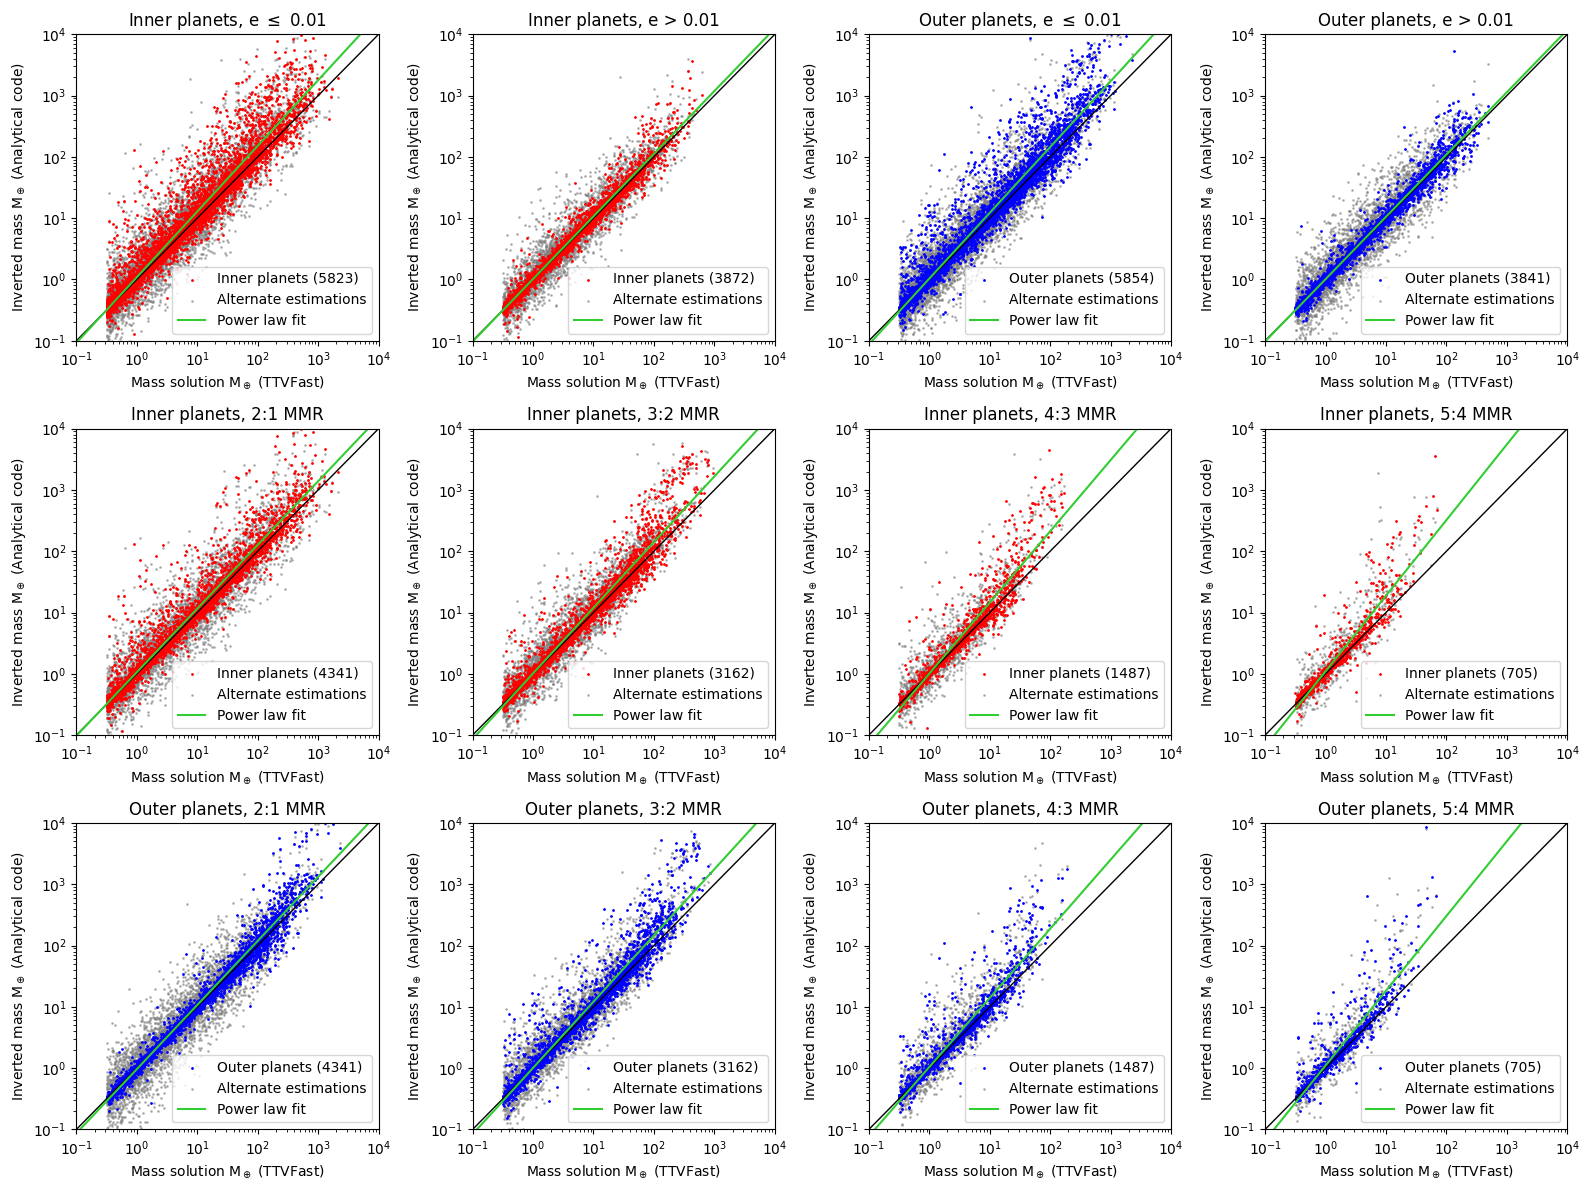

In [11]:
# Divide up by eccentricity and MMR
# Graph compare N-body outputs
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

def plotMassEstimation(posTuple, x, ygood, ybad, color, innerouterStr, mask, regimeName):
    s = 1
    minval = 1e-1
    maxval = 1e+4
    linelim = np.array([minval, maxval])
    scatterCount = len(x[mask])

    k, c = getLineFit(np.log10(ygood[mask]), np.log10(x[mask]))

    ax[posTuple].scatter(x[mask], ygood[mask], s=s, color=color, label=f'{innerouterStr} planets ({scatterCount})', zorder=0)
    ax[posTuple].scatter(x[mask], ybad[mask], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
    ax[posTuple].plot(linelim, linelim, color='black', lw=1, zorder=1)
    ax[posTuple].plot(linelim, 10**c * linelim**k, color='limegreen', label=f'Power law fit')
    ax[posTuple].set_xscale('log'); ax[posTuple].set_yscale('log')
    ax[posTuple].set_xlim(minval, maxval); ax[posTuple].set_ylim(minval, maxval)
    ax[posTuple].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
    ax[posTuple].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
    ax[posTuple].legend(loc='lower right')
    ax[posTuple].set_title(f'{innerouterStr} planets, {regimeName}')

def plotMassWithRegimes(df):
    # Regime definitions
    ethres = 0.01
    lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
    lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
    def jmask(n): 
        return (compare.j == n)
    
    # Eccentricity
    plotMassEstimation((0,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', lowe1, 'e $\leq$ 0.01')
    plotMassEstimation((0,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', highe1, 'e > 0.01')
    plotMassEstimation((0,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', lowe2, 'e $\leq$ 0.01')
    plotMassEstimation((0,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', highe2, 'e > 0.01')
    
    # MMR
    plotMassEstimation((1,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(2), '2:1 MMR')
    plotMassEstimation((1,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(3), '3:2 MMR')
    plotMassEstimation((1,2), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(4), '4:3 MMR')
    plotMassEstimation((1,3), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(5), '5:4 MMR')
    
    plotMassEstimation((2,0), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(2), '2:1 MMR')
    plotMassEstimation((2,1), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(3), '3:2 MMR')
    plotMassEstimation((2,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(4), '4:3 MMR')
    plotMassEstimation((2,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(5), '5:4 MMR')

plotMassWithRegimes(compare)

fig.tight_layout()
plt.show()

In [12]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): 0.069 dex, 0.020 dex, 0.225 dex
Geometric mean error, median error, and geometric STD (Outer): 0.054 dex, 0.013 dex, 0.202 dex


# Nominal validation

In [13]:
# Naive nominal mass validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities() for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    if valid[i] == False:  # If invalid column
        mcalc_in = np.append(mcalc_in, np.nan)
        mcalc_out = np.append(mcalc_out, np.nan)
        mbad_in = np.append(mbad_in, np.nan)
        mbad_out = np.append(mbad_out, np.nan)
        continue
    
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare_n = fits.copy()
compare_n['m_calc_in'] = mcalc_in
compare_n['m_calc_out'] = mcalc_out
compare_n['m_bad_in'] = mbad_in
compare_n['m_bad_out'] = mbad_out
compare_n.head()

100%|█████████████████████████████████████████████████████████████████████████████| 9695/9695 [01:00<00:00, 161.52it/s]


index        e1          w1        e2          w2     Delta  j  P1  \
0      1  0.029546  159.213181  0.001624  298.046206 -0.031463  3   7   
1      5  0.009029    1.796158  0.004746  257.200178 -0.001874  5   7   
2      8  0.002530  100.798272  0.016567   99.637520  0.038429  2   7   
3     14  0.034870  174.244943  0.018098  163.461676 -0.005177  5   7   
4     17  0.001254  295.465659  0.040271  276.500619 -0.046231  2   7   

          P2         m1  ...        V2       Pttv2    phase2      std2  \
0  10.169642   8.910582  ...  0.005739  108.599092  2.633932  0.004049   
1   8.733601   0.614201  ...  0.010711  818.691582  0.510303  0.007500   
2  14.538010  72.349777  ...  0.005850  195.240594  3.494568  0.004140   
3   8.704699   0.499981  ...  0.003705  349.673024  1.863791  0.002580   
4  13.352763   1.145732  ...  0.000136  143.907974  1.750301  0.000100   

       R2_1      R2_2  m_calc_in  m_calc_out   m_bad_in  m_bad_out  
0  0.949630  0.976690  20.574727    1.201166  23.928177   1.562532  
1  0.999054  0.998983   3.316435    7.266077   3.385991   7.471487  
2  0.993930  0.983871  87.605338    2.167002  61.698358   1.767231  
3  0.993851  0.993949   2.779876    5.953870   2.648425   5.577727  
4  0.977760  0.914513   1.866242   20.596423   2.891245  27.146687  

[5 rows x 34 columns]

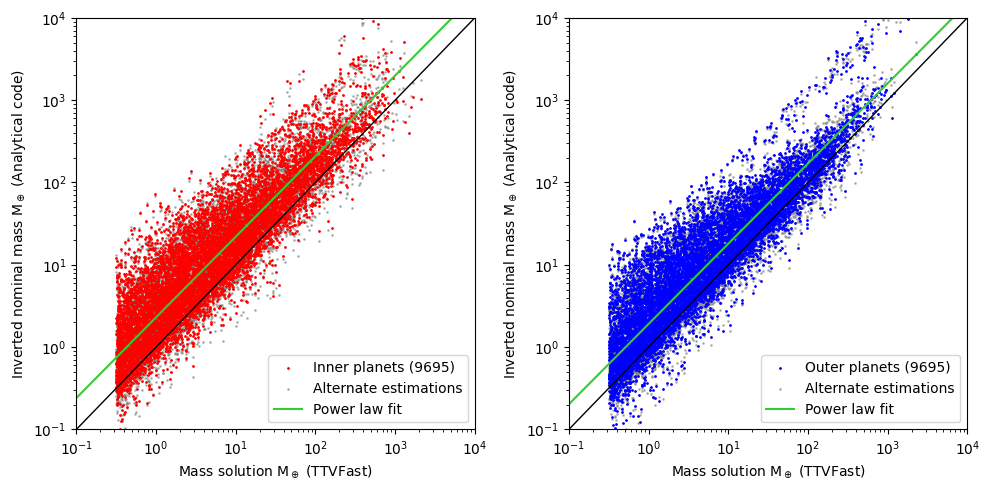

In [14]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4
linelim = np.array([minval, maxval])
scatterCount = len(compare_n['m1'])

# Inner planets
m1 = compare_n['m1']
m1_good = compare_n['m_calc_in']
m1_bad = compare_n['m_bad_in']
k1, c1 = getLineFit(np.log10(m1_good), np.log10(m1))

ax[0].scatter(m1, m1_good, s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(m1, m1_bad, s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot(linelim, linelim, color='black', lw=1, zorder=1)
ax[0].plot(linelim, 10**c1 * linelim**k1, color='limegreen', label=f'Power law fit')
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planet
m2 = compare_n['m2']
m2_good = compare_n['m_calc_out']
m2_bad = compare_n['m_bad_out']
k2, c2 = getLineFit(np.log10(m2_good), np.log10(m2))


ax[1].scatter(m2, compare_n['m_calc_out'], s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(m2, compare_n['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot(linelim, linelim, color='black', lw=1, zorder=1)
ax[1].plot(linelim, 10**c2 * linelim**k2, color='limegreen', label=f'Power law fit')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

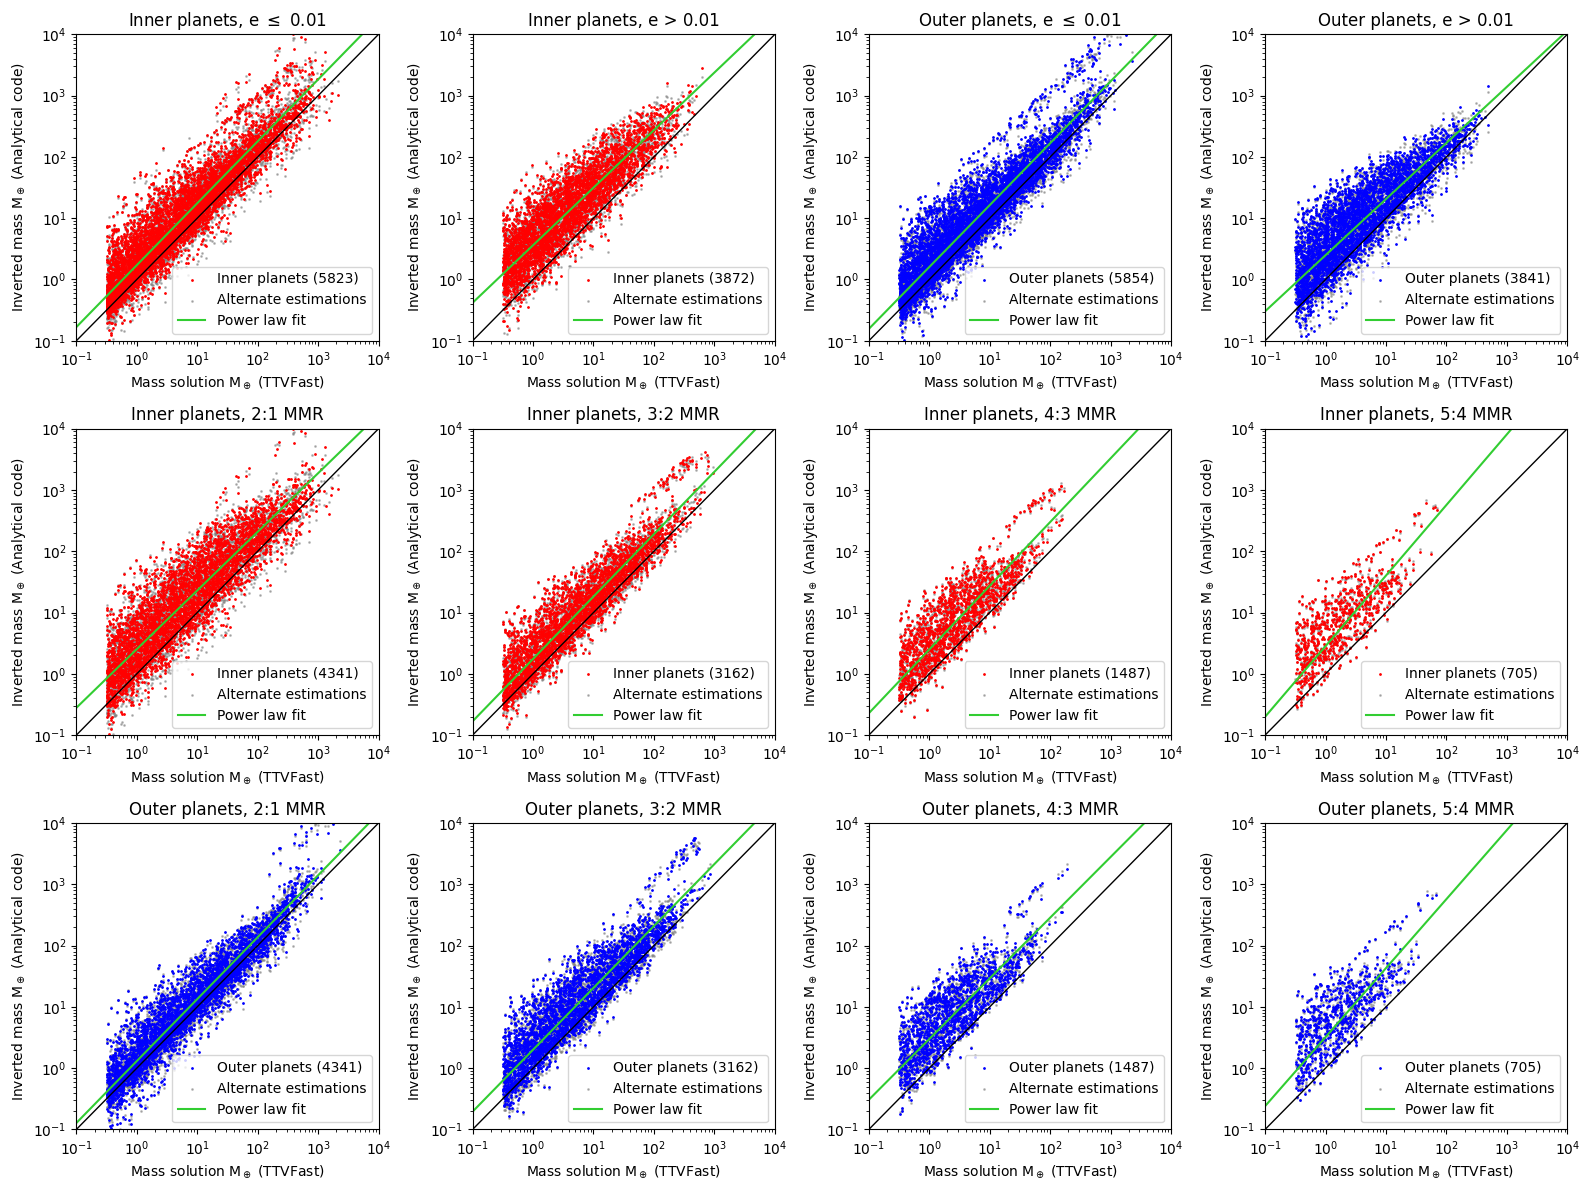

In [15]:
# Divide by regimes
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
plotMassWithRegimes(compare_n)
fig.tight_layout()
plt.show()

In [16]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare_n, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.3f} dex, {med1:.3f} dex, {gstd1:.3f} dex')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.3f} dex, {med2:.3f} dex, {gstd2:.3f} dex')

Geometric mean error, median error, and geometric STD (Inner): 0.386 dex, 0.339 dex, 0.366 dex
Geometric mean error, median error, and geometric STD (Outer): 0.300 dex, 0.233 dex, 0.354 dex


# Metric compilation

In [17]:
# Metric summarized in dataframe
metricCols = ['regime', 'count', 'GMerr', 'GMerr_n', 'MedErr', 'MedErr_n', 'p16Err', 'p16Err_n', 'p84Err', 'p84Err_n']
metrics = pd.DataFrame(columns=metricCols)
metrics.regime = ['Inner (Overall)', 'Inner (e = 0.001-0.01)', 'Inner (e = 0.01-0.1)',
                  'Inner (2:1 MMR)', 'Inner (3:2 MMR)', 'Inner (4:3 MMR)', 'Inner (5:4 MMR)',
                  'Outer (Overall)', 'Outer (e = 0.001-0.01)', 'Outer (e = 0.01-0.1)',
                  'Outer (2:1 MMR)', 'Outer (3:2 MMR)', 'Outer (4:3 MMR)', 'Outer (5:4 MMR)']
metrics.head()

regime count GMerr GMerr_n MedErr MedErr_n p16Err p16Err_n  \
0         Inner (Overall)   NaN   NaN     NaN    NaN      NaN    NaN      NaN   
1  Inner (e = 0.001-0.01)   NaN   NaN     NaN    NaN      NaN    NaN      NaN   
2    Inner (e = 0.01-0.1)   NaN   NaN     NaN    NaN      NaN    NaN      NaN   
3         Inner (2:1 MMR)   NaN   NaN     NaN    NaN      NaN    NaN      NaN   
4         Inner (3:2 MMR)   NaN   NaN     NaN    NaN      NaN    NaN      NaN   

  p84Err p84Err_n  
0    NaN      NaN  
1    NaN      NaN  
2    NaN      NaN  
3    NaN      NaN  
4    NaN      NaN

In [18]:
# Regime definitions
ethres = 0.01
lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
def jmask(n): 
    return (compare.j == n)

# Create values to insert
def createListToInsert(innerOuterStr, m):
    err1, err2, med1, med2, p16_1, p84_1, p16_2, p84_2 = returnMetrics(compare, mask=m, mode='percentile')
    err1n, err2n, med1n, med2n, p16_1n, p84_1n, p16_2n, p84_2n = returnMetrics(compare_n, mask=m, mode='percentile')

    if innerOuterStr == 'Inner':
        metrics = [err1, err1n, med1, med1n, p16_1, p16_1n, p84_1, p84_1n]
    elif innerOuterStr == 'Outer':
        metrics = [err2, err2n, med2, med2n, p16_2, p16_2n, p84_2, p84_2n]

    count = len(compare.m1) if (isinstance(m, str) == True) else len(compare.m1[m])
    return [count, *metrics]

rows = []
for io in ['Inner', 'Outer']:
    for regime in ['all', 'lowe', 'highe', *[jmask(n) for n in range(2,6)]]:
        r = regime
        if isinstance(r, str):
            r = lowe1 if (regime == 'lowe') and (io == 'Inner') else r
            r = lowe2 if (regime == 'lowe') and (io == 'Outer') else r
            r = highe1 if (regime == 'highe') and (io == 'Inner') else r
            r = highe2 if (regime == 'highe') and (io == 'Outer') else r
        rowi = createListToInsert(io, m=r)
        rows.append(rowi)

# Inserting time
for i, r in enumerate(rows):
    metrics.loc[i, metricCols[1:]] = r

metrics

regime count     GMerr   GMerr_n    MedErr  MedErr_n  \
0          Inner (Overall)  9695  0.069411  0.386479  0.020166  0.338683   
1   Inner (e = 0.001-0.01)  5823  0.100867  0.271905  0.028647   0.21654   
2     Inner (e = 0.01-0.1)  3872  0.022356  0.557837  0.013161  0.538057   
3          Inner (2:1 MMR)  4341  0.065054  0.397468  0.018887  0.361291   
4          Inner (3:2 MMR)  3162  0.063563  0.287805    0.0209   0.24053   
5          Inner (4:3 MMR)  1487  0.078439  0.466647  0.018761  0.413096   
6          Inner (5:4 MMR)   705  0.103162  0.592749  0.031053  0.542334   
7          Outer (Overall)  9695  0.054168  0.300057  0.013494  0.233454   
8   Outer (e = 0.001-0.01)  5854  0.079501  0.243516  0.018873  0.167745   
9     Outer (e = 0.01-0.1)  3841  0.015763  0.385761  0.007955  0.342513   
10         Outer (2:1 MMR)  4341  0.024408  0.139054  0.005764  0.094443   
11         Outer (3:2 MMR)  3162  0.069572  0.342404  0.021188  0.294731   
12         Outer (4:3 MMR)  1487  0.082025  0.517109  0.019431  0.471889   
13         Outer (5:4 MMR)   705  0.108028  0.635665   0.03128  0.589162   

      p16Err  p16Err_n    p84Err  p84Err_n  
0  -0.047095  0.039361  0.149997  0.766033  
1  -0.053953 -0.014458    0.2398  0.577647  
2  -0.038577  0.217776  0.067454  0.914774  
3  -0.046843   0.02545  0.144458  0.793266  
4  -0.053198  0.003537  0.143418  0.598588  
5  -0.038229  0.121217  0.169294  0.853652  
6   -0.03671  0.217538  0.191697  0.979106  
7  -0.041683 -0.009745  0.115222  0.659634  
8  -0.042175 -0.027221  0.176422   0.54414  
9  -0.041329  0.036571  0.060155   0.77749  
10 -0.043101 -0.082186  0.071697  0.392977  
11 -0.043103  0.040205  0.141799  0.677337  
12 -0.035769  0.156778  0.175376  0.917115  
13 -0.036808   0.25861  0.205702  1.027591

In [19]:
# Export metrics
metrics.to_csv('lithwick_code_metrics.csv', index=False)

In [20]:
# Plot visualization
inner = metrics[0:7]; outer = metrics[7:14]

def metricPlots(df, innerOuterStr):
    regimenames = ['Overall', 'e≤0.01', 'e>0.01', '2:1', '3:2', '4:3', '5:4']
    colnames = ['Regime', 'Count', 'Geometric Mean Error [dex]', 'Geometric Mean Error (Nominal) [dex]',
                'Median Error [dex]', 'Median Error (Nominal) [dex]',
                'Error at 16th Percentile [dex]', 'Error at 16th Percentile (Nominal) [dex]',
                'Error at 84th Percentile [dex]', 'Error at 84th Percentile (Nominal) [dex]']

    yerr_lower = df.MedErr - df.p16Err; yerr_upper = df.p84Err - df.MedErr
    yerr = [yerr_lower, yerr_upper]
    
    yerrn_lower = df.MedErr_n - df.p16Err_n; yerrn_upper = df.p84Err_n - df.MedErr_n
    yerrn = [yerrn_lower, yerrn_upper]
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    ax[0].errorbar(x=regimenames, y=df.MedErr, yerr=yerr, fmt='D', linestyle='none', color='black')
    ax[0].set_title(f'{innerOuterStr} planet mass fractional error by regime')
    ax[0].set_ylim(top=df['p84Err'].max() * 1.15)
    ax[1].errorbar(x=regimenames, y=df.MedErr_n, yerr=yerrn, fmt='D', linestyle='none', color='black')
    ax[1].set_title(f'{innerOuterStr} planet mass fractional error by regime (Nomimal)')
    ax[1].set_ylim(top=df['p84Err_n'].max() * 1.15)

    for i in range(7): # Text
        xpos = regimenames[i]
        s1 = 10
        s2 = 6
        
        upper = df['p84Err'].iloc[i] - df['MedErr'].iloc[i]
        lower = df['MedErr'].iloc[i] - df['p16Err'].iloc[i]
        ax[0].text(  # Left plot median + errorbar
            xpos,
            df['p84Err'].iloc[i] * 1.03,
            f'{df.MedErr.iloc[i]:.3f}',
            fontsize=s1,
            ha='right', va='bottom'
        )
        ax[0].text(
            xpos,
            df['p84Err'].iloc[i] * 1.01,
            f'+{upper:.3f}\n-{lower:.3f}',
            fontsize=s2,
            ha='left', va='bottom'
        )

        upper_n = df['p84Err_n'].iloc[i] - df['MedErr_n'].iloc[i]
        lower_n = df['MedErr_n'].iloc[i] - df['p16Err_n'].iloc[i]
        ax[1].text( # Right plot median + errorbar
            xpos,
            df['p84Err_n'].iloc[i] * 1.03,
            f'{df.MedErr_n.iloc[i]:.3f}',
            fontsize=s1,
            ha='right', va='bottom'
        )
        ax[1].text(
            xpos,
            df['p84Err_n'].iloc[i] * 1.01,
            f'+{upper_n:.3f}\n-{lower_n:.3f}',
            fontsize=s2,
            ha='left', va='bottom'
        )
    
    for a in ax:
        a.axhline(0, color='black', linestyle='--', linewidth=1)
        a.set_ylabel(f'Fractional error [dex]')
        a.set_xlabel(f'Regime ({innerOuterStr} planets)')
        a.margins(x=0.1)

    plt.show()

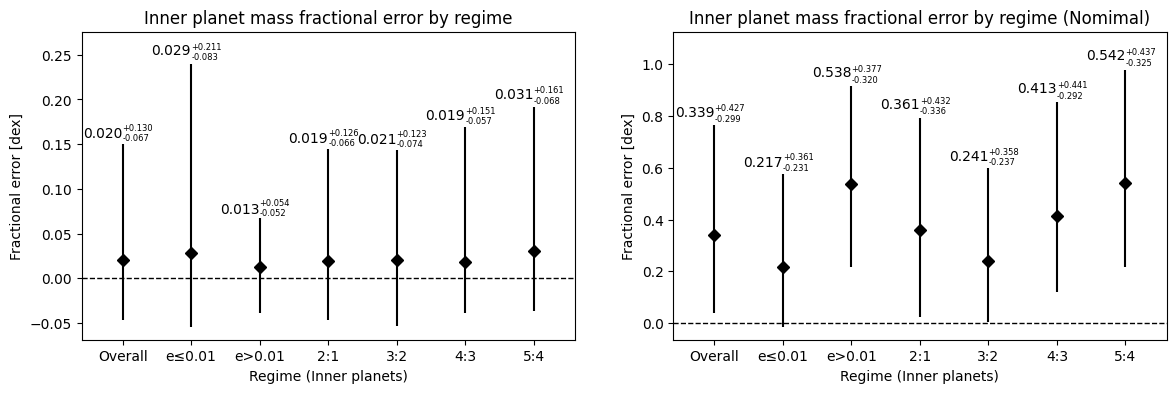

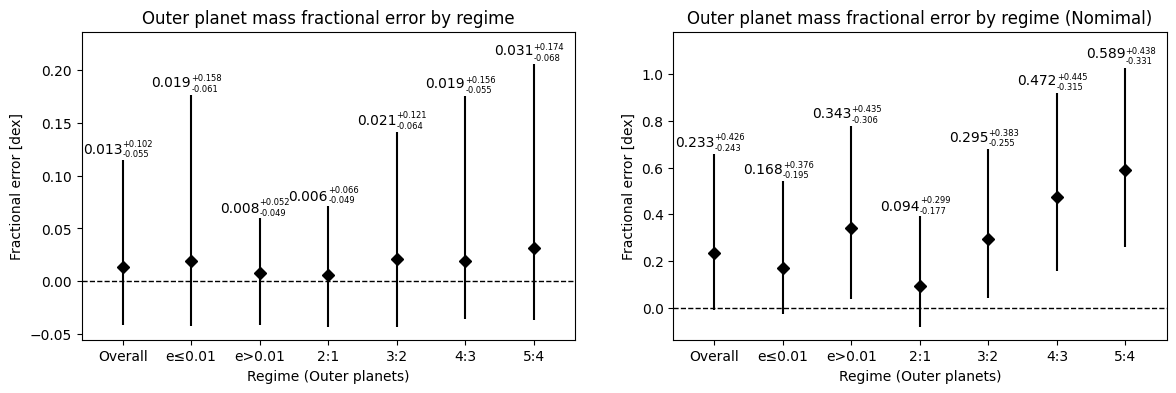

In [21]:
metricPlots(inner, 'Inner')
metricPlots(outer, 'Outer')